# Monet Painting - GANs by Marshall Folkman

## Github Link

## Problem Description

In the realm of art, renowned artists like Claude Monet have signature styles that distinguish their masterpieces. The digital revolution, specifically the advent of deep learning, has introduced the capability to mimic such unique artistic flair using Generative Adversarial Networks (GANs). This competition merges the essence of art with the precision of data science, challenging participants to not only replicate the Monet style but to produce images so authentic that they could be mistaken for genuine Monet works.

## Data Description

The dataset consists of four directories, offering both Monet's paintings and regular photos in two formats: JPEG and TFRecord. Specifically, there are 300 Monet paintings and 7028 photos, all sized at 256x256 pixels. Participants are tasked with training their model on the Monet images and then applying or generating the Monet style to the photos. The end goal is to craft and submit 7,000 to 10,000 Monet-inspired images, encapsulating the challenge's blend of artistic creativity and technological expertise. I will use the recommended photos as the getting started way to do this assignment.

## EDA

In [1]:
# Requires: pip install nbconvert ipykernel pandas matplotlib seaborn tensorflow scikit-learn
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)
from PIL import Image
import random
from hashlib import md5
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization, UpSampling2D, Conv2D, Activation
from keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
from sklearn.metrics import mean_squared_error
from tensorflow import reduce_mean
from tqdm.notebook import tqdm
from tensorflow.keras.losses import binary_crossentropy
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from functools import partial
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.summary import create_file_writer
import datetime

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
## ONLY RUN THIS CODE IF RUN FROM GOOGLE COLABORATORY
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths to the zipped datasets on Google Drive
import zipfile
monet_zip_path = "/content/drive/My Drive/Colab Notebooks/monet_jpg.zip"
photo_zip_path = "/content/drive/My Drive/Colab Notebooks/photo_jpg.zip"

def unzip_dataset(zip_path, dest_dir):
    """
    Unzips a dataset from a specified path to a destination directory.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

# Destination directories for the datasets
monet_unzip_dir = "/content/drive/My Drive/Colab Notebooks/monet_jpg"
photo_unzip_dir = "/content/drive/My Drive/Colab Notebooks/photo_jpg"

# Load Monet paintings
monet_images = [Image.open(os.path.join(monet_unzip_dir, filename)) for filename in os.listdir(monet_unzip_dir) if filename.endswith('.jpg')]

# Load photos
photo_images = [Image.open(os.path.join(photo_unzip_dir, filename)) for filename in os.listdir(photo_unzip_dir) if filename.endswith('.jpg')]

print(len(monet_images))
print(len(photo_images))

Mounted at /content/drive


In [ ]:
## ONLY RUN THIS CODE IF RUN FROM LOCAL MACHINE
# Define paths
#monet_dir = "D:\OneDrive\_CU-MSEE\AI\DTSA5511_DeepLearning\Week5\gan-getting-started\monet_jpg"
#photo_dir = "D:\OneDrive\_CU-MSEE\AI\DTSA5511_DeepLearning\Week5\gan-getting-started\photo_jpg"

# Load Monet paintings
#monet_images = [Image.open(os.path.join(monet_dir, filename)) for filename in os.listdir(monet_dir) if filename.endswith('.jpg')]

# Load photos
#photo_images = [Image.open(os.path.join(photo_dir, filename)) for filename in os.listdir(photo_dir) if filename.endswith('.jpg')]

In [ ]:
# Display some samples
plt.figure(figsize=(12, 6))

# Display a few Monet paintings
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(monet_images[i])
    plt.title("Monet Painting")
    plt.axis('off')

# Display a few photos
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(photo_images[i])
    plt.title("Photo")
    plt.axis('off')

plt.tight_layout()
plt.show()

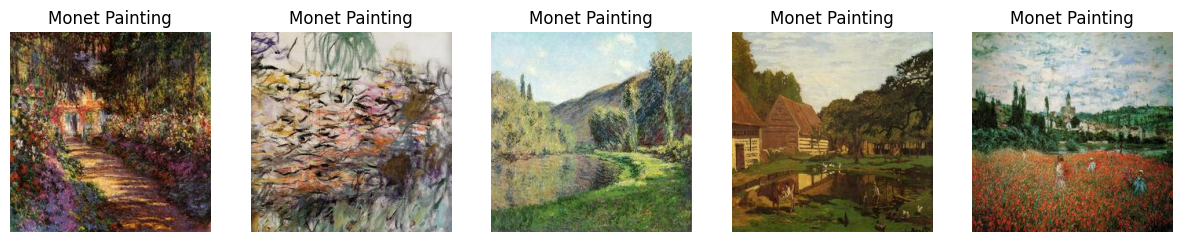

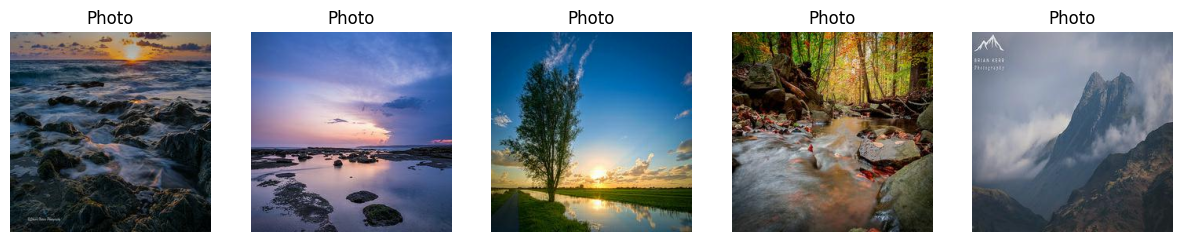

In [ ]:
# Lets see some more at random
def display_images(images, title, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(random.choice(images))
        plt.title(title)
        plt.axis('off')
    plt.show()

display_images(monet_images, "Monet Painting")
display_images(photo_images, "Photo")

In [ ]:
# Compute the mean and standard deviation of pixel values.
def image_stats(images):
    all_pixels = np.array([np.array(img) for img in images])
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)
    return mean, std

monet_mean, monet_std = image_stats(monet_images)
photo_mean, photo_std = image_stats(photo_images)

print(f"Monet Images - Mean: {monet_mean}, Standard Deviation: {monet_std}")
print(f"Photo Images - Mean: {photo_mean}, Standard Deviation: {photo_std}")

In [ ]:
# Plot the distribution of RGB colors to understand the color intensity distribution in the datasets.
def plot_color_distribution(images, title):
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(15, 5))

    for idx, color in enumerate(colors):
        plt.subplot(1, 3, idx+1)
        all_pixels = np.array([np.array(img)[:,:,idx].ravel() for img in images]).ravel()
        plt.hist(all_pixels, bins=50, color=color, alpha=0.5)

        # Axis labels and title
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title(f"{title} - {color.upper()} Distribution")

    plt.tight_layout()
    plt.show()

plot_color_distribution(monet_images, "Monet Painting")
plot_color_distribution(photo_images, "Photo")

In [ ]:
# Use hashing to identify and remove duplicate images.
def get_duplicates(images):
    hash_dict = {}
    duplicates = []
    for img in images:
        h = md5(np.array(img).tobytes()).hexdigest()
        if h in hash_dict:
            duplicates.append(img)
        else:
            hash_dict[h] = img
    return duplicates

monet_duplicates = get_duplicates(monet_images)
photo_duplicates = get_duplicates(photo_images)

print(f"Number of duplicate Monet paintings: {len(monet_duplicates)}")
print(f"Number of duplicate photos: {len(photo_duplicates)}")

In [ ]:
# Confirm all images are 256x256 pixels
def check_image_dimensions(images):
    unique_dims = {img.size for img in images}
    return unique_dims

print(f"Unique dimensions in Monet paintings: {check_image_dimensions(monet_images)}")
print(f"Unique dimensions in photos: {check_image_dimensions(photo_images)}")

## Cleaning and Preprocessing

### Cleaning (Remove Duplicates)

In [ ]:
def remove_duplicates(images):
    hash_dict = {}
    unique_images = []

    for img in images:
        h = md5(np.array(img).tobytes()).hexdigest()
        if h not in hash_dict:
            hash_dict[h] = img
            unique_images.append(img)

    return unique_images

# Assuming photo_images contains all the photos
photo_images_cleaned = remove_duplicates(photo_images)

print(f"Original number of photos: {len(photo_images)}")
print(f"Number of photos after removing duplicates: {len(photo_images_cleaned)}")

### Preprocess the Monet Data

Before we jump into building the GAN, we need to preprocess the Monet paintings to ensure that they are in the appropriate format for training. Here, we'll normalize the images and create a TensorFlow Dataset.

In [ ]:
def preprocess_image(image, mean, std):
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) - mean) / std
    return image

def load_and_preprocess_image(image_path, mean, std):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    return preprocess_image(image, mean, std)

monet_file_paths = [os.path.join(monet_unzip_dir, filename) for filename in os.listdir(monet_unzip_dir) if filename.endswith('.jpg')]
monet_ds = tf.data.Dataset.from_tensor_slices(monet_file_paths)
monet_ds = monet_ds.map(lambda x: load_and_preprocess_image(x, monet_mean, monet_std))
monet_ds = monet_ds.batch(32, drop_remainder=True).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

photo_file_paths = [os.path.join(photo_unzip_dir, filename) for filename in os.listdir(photo_unzip_dir) if filename.endswith('.jpg')]
photo_ds = tf.data.Dataset.from_tensor_slices(photo_file_paths)
photo_ds = photo_ds.map(lambda x: load_and_preprocess_image(x, photo_mean, photo_std))
photo_ds = photo_ds.batch(32, drop_remainder=True).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Training - Building a Simple GAN

### Build Generator
Tries to generate fake images.

In [ ]:
def build_generator():
    model = Sequential()

    model.add(Dense(64 * 64 * 128, activation="relu", input_shape=(100,)))
    model.add(Reshape((64, 64, 128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Dropout(0.25)) # Added Dropout layer

    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

### Build Discriminator
Tries to distinguish between real and fake images.

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(256, 256, 3)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8)) # Added BatchNormalization
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8)) # Added BatchNormalization
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, kernel_size=4, strides=2, padding='same')) # Added Conv2D layer
    model.add(BatchNormalization(momentum=0.8)) # Added BatchNormalization
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def compile_discriminator(discriminator, optimizer=Adam(learning_rate=0.0004, beta_1=0.5, clipvalue=0.01)):
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator

Combine the Generator and Discriminater into 1 Model

In [ ]:
def compile_gan(generator, discriminator, optimizer=Adam(learning_rate=0.0001, beta_1=0.5, clipvalue=0.01)):
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')

    return gan

def generate_samples(generator, noise_dim, batch_size=1):
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    generated_image = generator.predict(noise)
    return generated_image

Setup for Performance Monitoring

### Basic training loop for the GAN

In [ ]:
def sample_images(generator, step, noise_dim=128, grid_shape=(1, 4)):
    noise = np.random.normal(0, 1, (grid_shape[0] * grid_shape[1], noise_dim))
    generated_images = generator.predict(noise)

    # Rescale the pixel values from [-1, 1] to [0, 1] if necessary
    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(grid_shape[0], grid_shape[1])

    # Check if there's only one row
    if grid_shape[0] == 1:
        axs = [axs]  # Convert axs to a list of axes

    cnt = 0
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            axs[i][j].imshow(generated_images[cnt])
            axs[i][j].axis('off')
            cnt += 1

    plt.show()
    plt.close()

In [ ]:
def compute_color_distribution(images):
    histograms = []
    for channel in range(3): # For each color channel (R, G, B)
        hist = tf.histogram_fixed_width(images[:,:,:,channel], [0, 1], nbins=256) # Updated the range to [0, 1]
        histograms.append(hist)
    histograms = tf.stack(histograms, axis=-1)
    return histograms

def color_distribution_loss(real_images, generated_images):
    # Computing the color distribution for real and generated images
    real_distribution = compute_color_distribution(real_images)
    generated_distribution = compute_color_distribution(generated_images)
    # Adding small constant to avoid division by zero and logarithm of zero
    real_distribution = tf.cast(real_distribution, tf.float32) + 1e-8
    generated_distribution = tf.cast(generated_distribution, tf.float32) + 1e-8
    loss = tf.reduce_sum(real_distribution * tf.math.log(real_distribution / generated_distribution))
    return tf.cast(loss, tf.float32)  # Casting to float32

In [ ]:
def train_gan(generator, discriminator, gan, dataset, epochs=5000, batch_size=32, sample_interval=500, noise_dim=100):
    half_batch = batch_size // 2
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    summary_writer = tf.summary.create_file_writer(log_dir)

    if tf.data.experimental.cardinality(dataset).numpy() == 0:
        print("The dataset is empty. Training cannot proceed.")
        return

    print(f"Number of batches: {tf.data.experimental.cardinality(dataset.batch(half_batch)).numpy()}")

    for epoch in range(epochs):
        print(f"Starting epoch {epoch}")

        for batch_idx, real_images in enumerate(dataset):
            real_images = real_images.numpy()

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_images = generator.predict(noise[:half_batch])

            d_loss_real = discriminator.train_on_batch(real_images[:half_batch], np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

            # Calculate accuracy
            real_preds = discriminator.predict(real_images[:half_batch]) > 0.5
            fake_preds = discriminator.predict(fake_images) < 0.5
            d_acc = (np.sum(real_preds) + np.sum(fake_preds)) / (2 * half_batch)

            with summary_writer.as_default():
                tf.summary.scalar('discriminator_loss', d_loss[0], step=epoch)
                tf.summary.scalar('discriminator_accuracy', d_acc, step=epoch)
                tf.summary.scalar('generator_loss', g_loss, step=epoch)

        if epoch % sample_interval == 0:
            print(f"Sampling images at epoch {epoch}")
            print(f"Generator Loss: {g_loss}")
            print(f"Discriminator Loss: {d_loss}")
            print(f"Discriminator Accuracy: {d_acc * 100:.2f}%")
            sample_images(generator, epoch, noise_dim=noise_dim)

    print("Training completed")
    sample_images(generator, epochs, noise_dim=noise_dim)

In [ ]:
# Building the models
generator = build_generator()
discriminator = build_discriminator()
gan = compile_gan(generator, discriminator)

# Compiling the models
discriminator = compile_discriminator(discriminator)

# Training the models
train_gan(generator, discriminator, gan, monet_ds, epochs=30, batch_size=64, sample_interval=5)

### Show Training Results

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs/fit


## Create final submission to be graded by Kaggle

In [ ]:
# Print the generator's expected input shape
input_shape = generator.input_shape[1:] # Correct way to get the input shape
print(f"Generator expects input shape: {input_shape}")

# Define the transformation function according to the generator's expected shape
def transform_image(image):
    # Print the shape of the image to diagnose the issue
    print(f"Shape of the image before reshaping: {image.shape}")

    # You may need to make further adjustments to this code, depending on how you intend to use the `transform_image` function
    # For now, the code is expecting a noise vector of shape (100,), so it's not clear how the image should be transformed
    noise_vector = np.random.normal(0, 1, (1, *input_shape))
    return generator.predict(noise_vector)[0]

# Rest of the code remains the same

In [ ]:
# Print the generator's expected input shape for debugging
input_shape = generator.layers[0].input_shape[1:]
print(f"Generator expects input shape: {input_shape}")

# Directory to save the images
image_directory = '/content/drive/My Drive/Colab Notebooks/images'
os.makedirs(image_directory, exist_ok=True)

# Loop over the number of images you want to generate
noise_dim = 100
for idx in tqdm(range(len(photo_images_cleaned)), desc='Generating Images'):
    # Generate a random noise vector
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Use the generator to create a fake image from the noise
    transformed_image = generator.predict(noise)

    # Post-process the image if needed
    transformed_image = (transformed_image * 255).astype('uint8')

    # Convert to PIL Image and save
    transformed_image_pil = Image.fromarray(transformed_image[0])
    transformed_image_pil.save(f'{image_directory}/image_{idx}.jpg')

# Path to save the zip file
zip_path = '/content/drive/My Drive/Colab Notebooks/images.zip'

# Zip the images
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(image_directory):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), image_directory))

## Results

## Conclusion